# HOOMD-blue Langevin dynamics simulation of colloidal system 

**Author**: _Ye Nguyen Edalgo_

**Description**:
    1. Running Langevin dynamics 
    2. colloidal system of 8000 nanoparticles following LJ model 
    3. adding feature of magnetic dipole-dipole interaction between NPs

In [4]:
"""Initialization"""
import os
from math import *
import numpy as np
import hoomd
import hoomd.md
import hoomd.deprecated
hoomd.context.initialize("");

HOOMD-blue 2.3.1 DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


**Parameters**

Parameter values are obtained from LAMMPS simulation of magnetic colloids by Faraudo_2011_SI [(link)](https://pubs.rsc.org/en/content/articlelanding/2011/sm/c0sm01424a#!divAbstract)

In [6]:
"""Output filename (User defined Var)"""
change_seed = 50
type = 'weakCoupling'
Equil_fname = 'Data/trajectory_Equil_5.gsd'

In [12]:
"""Reference value (User defined Var)"""
mass            = 5.24e-19                                  #kg/particle
LJ_sigma        = 100                                       #nm 
LJ_epsilon      = 1.3e-20                                   #J or kg m2 s-2
time_scale      = LJ_sigma*(mass/LJ_epsilon)**(1/2)*1e-9    #sec
kB              = 1.38064852e-23                            #kg m2 s-2 K-1

"""Real Units (User defined Var)"""
par_ls          = 20                   #particle  
box_length      = 9.3e3                 #nm
NP_diameter     = 100                  #nm
r_cut_LJ        = NP_diameter          #nm 
r_cut_dd        = 1000                 #nm 
time_step       = 1.01e-10              #s  
viscosity       = 8.5251e-4            #N m-2 s-1 #NIST at water density=1000g/L
damp            = mass / (3*pi * viscosity * NP_diameter*1e-9) #s
#damp            = 0.5545e-9            #s
#damp            = 55.6e-9              #s
T               = 300                  #K  
dipole_moment   = 1.44e-17             #J/T 
mag_const       = 4*pi*1e-7            #T m A-1 
sim_time        = 0.1                  #s  
log_period      = 0.51e-3              #s                   

"""Lennard-Jones style Normalized"""
mass_r          = 1 
LJ_sigma_r      = 1 
LJ_epsilon_r    = 1 
box_length_r    = box_length / LJ_sigma 
NP_diameter_r   = NP_diameter / LJ_sigma 
r_cut_LJ_r      = r_cut_LJ / LJ_sigma
r_cut_dd_r      = r_cut_dd / LJ_sigma 
time_step_r     = time_step / time_scale
damp_r          = damp / time_scale
drag_coeff_r    = 0.0001 * mass_r / damp_r
T_r             = T * kB / LJ_epsilon
dipole_moment_r = dipole_moment / ((4*pi/mag_const*(LJ_sigma*1e-9)**3*LJ_epsilon)**(1/2))                              
sim_time_r      = sim_time / time_scale
log_period_r    = log_period / time_scale

print("mass: "+str(mass_r),
      "sigma: "+str(LJ_sigma_r),
      "epsilon: "+str(LJ_epsilon_r),
      "box_length: "+str(box_length_r), 
      "r_cut_LJ: "+str(r_cut_LJ_r), 
      "r_cut_dd: "+str(r_cut_dd_r), 
      "time_step: "+str(time_step_r), 
      "damp: "+str(damp)+ " s",
      "re-scale reduced drag: "+str(drag_coeff_r), 
      "Temp: "+str(T_r),
      "dipole_moment: "+str(dipole_moment_r),
      "sim_time: "+str(sim_time)+" sec",
      "log_period: "+str(sim_time/log_period)+" frames",
      sep="\n")

"""Concentration, volume fraction, and diffusion Check"""
sys_vol         = box_length**3*1e-24                       #liter
par_vol         = 4/3*pi*(NP_diameter/2)**3*1e-24           #liter
concentration   = mass*par_ls**3*1e3/sys_vol                #g/L
vol_fraction    = format(par_vol*par_ls**3/sys_vol, 'e')
diffusion_coeff = kB*T / (3*pi*viscosity*NP_diameter*1e-9) 
print("concentration is "+str(concentration)+" g/L")
print("volume fraction is "+str(vol_fraction))
print("D_theory is "+str(diffusion_coeff)+" m2/s")
print("corrected damp: "+str(damp)+" s")

mass: 1
sigma: 1
epsilon: 1
box_length: 93.0
r_cut_LJ: 1.0
r_cut_dd: 10.0
time_step: 0.00015908433118154948
damp: 6.521697902284872e-10 s
re-scale reduced drag: 0.09734940238013003
Temp: 0.3186111969230769
dipole_moment: 1.262963547802122
sim_time: 0.1 sec
log_period: 196.078431372549 frames
concentration is 5.211616235079696 g/L
volume fraction is 5.207626e-03
D_theory is 5.155060624051553e-12 m2/s
corrected damp: 6.521697902284872e-10 s


In [6]:
"""System preparation"""
uc = hoomd.lattice.unitcell(N = 1,
                        a1 = [box_length_r, 0, 0],
                        a2 = [0, box_length_r, 0], 
                        a3 = [0, 0, box_length_r], 
                        dimensions = 3, 
                        mass = [mass_r], 
                        diameter = [NP_diameter_r])
system = hoomd.init.create_lattice(uc, n=par_ls)

neighbor_ls = hoomd.md.nlist.tree();

notice(2): Group "all" created containing 8000 particles
-----
You are using tree neighbor lists. Please cite the following:
* M P Howard, J A Anderson, A Nikoubashman, S C Glotzer, and A Z
  Panagiotopoulos. "Efficient neighbor list calculation for molecular simulation
  of colloidal systems using graphics processing units", Computer Physics
  Communications 203 (2016) 45--52
-----


In [7]:
"""Integrator"""
hoomd.md.integrate.mode_standard(dt=time_step_r, aniso=None);
all = hoomd.group.all();
integrator = hoomd.md.integrate.langevin(group=all, kT=T_r, seed=change_seed); 
integrator.set_gamma('A', gamma=drag_coeff_r)

notice(2): integrate.langevin/bd is using specified gamma values


In [8]:
"""Output""" 

hoomd.analyze.log(filename='Data/log-output_'+type+'.log',
                   quantities=['potential_energy', 'temperature'],
                   period=log_period_r,
                   overwrite=True);   

hoomd.dump.gsd('Data/trajectory_'+type+'.gsd', period=log_period_r, group=all, overwrite=True);     

hoomd.deprecated.analyze.msd(filename='Data/msd_'+type+'.log',
                  groups=[all],
                  period=log_period_r,
                  overwrite=True)

In [9]:
hoomd.run(sim_time_r);

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 8000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:27 | Step 16119 / 157509 | TPS 1611.84 | ETA 00:01:27
Time 00:00:37 | Step 32521 / 157509 | TPS 1640.12 | ETA 00:01:16
Time 00:00:47 | Step 49842 / 157509 | TPS 1732.05 | ETA 00:01:02
Time 00:00:57 | Step 65944 / 157509 | TPS 1610.17 | ETA 00:00:56
Time 00:01:07 | Step 82252 / 157509 | TPS 1630.78 | ETA 00:00:46
Time 00:01:17 | Step 95804 / 157509 | TPS 1354.99 | ETA 00:00:45
Time 00:01:27 | Step 107559 / 157509 | TPS 1175.44 | ETA 00:00:42
Time 00:01:37 | Step 125001 / 157509 | TPS 1744.03 | ETA 00:00:18
Time 00:01:47 | Step 141247 / 157509 | TPS 1624.58 | ETA 00:00:10
Time 00:01:57 | Step 157241 / 157509 | TPS 1599.4 | ETA 00:00:00
Time 00:01:57 | Step 157509 / 157509 | TPS 1706.04 | ETA 00:00:00
Average TPS: 1572.52
---------
-- Neigh

**Calculate msd**

\begin{equation}
    \langle r^2 \rangle = \langle x^2 \rangle + \langle y^2 \rangle + \langle z^2 \rangle
\end{equation}

\begin{equation}
    \langle x^2 \rangle= \frac{1}{N}\sum^N_{i=1}\big(x(t)-x(0)\big)^2
\end{equation}

\begin{equation}
    \langle y^2 \rangle= \frac{1}{N}\sum^N_{i=1}\big(y(t)-y(0)\big)^2
\end{equation}

\begin{equation}
    \langle z^2 \rangle= \frac{1}{N}\sum^N_{i=1}\big(z(t)-z(0)\big)^2
\end{equation}

where $\langle r^2 \rangle$ is the mean square displacement for a Brownian partilce in 3D; $x(t)$, $y(t)$, $z(t)$ are positions of each particle in the $xyz$ coordinates at time $t$, respectively; $N$ is the number of particles.

**Calculate diffusion coefficient**

Diffusion coefficient obtained from the simulation trajectory ($D_{sim}$) is evaluated as:

\begin{equation}
     D_{sim} = \frac{\langle r^2 \rangle}{6t}
\end{equation}

$D_{sim}$ is compared with the diffusion coefficient obtained from theory $D_{theory}$ given as:

\begin{equation}
    D_{theory} = \frac{k_BT}{3\pi\eta d_p}
\label{D_theory}
\end{equation}

From Stokes's Law, the solvent viscosity $\eta$ is given as:

\begin{equation}
    \eta = \frac{m}{3\pi\tau d_p}
\label{Viscosity}
\end{equation}

where $k_B T$ is the Boltzmann temperature, $d_p$ is the diameter of the colloidal particle, $m$ is the mass of each particle, and $\tau$ is the damping parameter. 

D_sim = 2.623133333333333e-09 m2/s
D_theory is 5.155060624051553e-12 m2/s


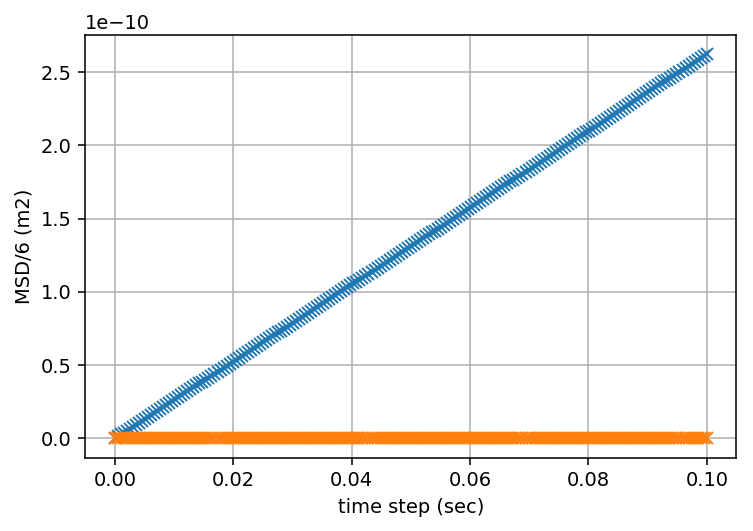

In [13]:
"""Plotting msd vs. time"""
import numpy as np 

msd = np.genfromtxt(fname='Data/msd_'+type+'.log', skip_header=True);
x = np.arange(0,sim_time,log_period) 
y = 1/6 * msd * (LJ_sigma*1e-9)**2

Dif_coef = 1/6 * msd[-1,0] * (LJ_sigma*1e-9)**2 / sim_time
print('D_sim = '+str(Dif_coef)+' m2/s')
print("D_theory is "+str(diffusion_coeff)+" m2/s")

from matplotlib import pyplot as plt
plt.figure(figsize=None, dpi=140);
plt.plot(x, y, 'x');
plt.xlabel('time step (sec)');
plt.ylabel('MSD/6 (m2)')
#plt.ylabel('$\frac{\langle r^2 \rangle}{6}$ (m^2)');
plt.grid(True)
plt.savefig('Figures/msd_calc_'+type+'.pdf')

In [ ]:
"""Lennard-Jones Potential"""
LJ = hoomd.md.pair.lj(r_cut=r_cut_LJ_r, nlist=neighbor_ls);
LJ.pair_coeff.set('A', 'A', epsilon=LJ_epsilon_r, sigma=LJ_sigma_r);

"""Dipole-Dipole Potential: SWITCH ON After system is equilibrated""" 
DD = hoomd.md.pair.dipole(r_cut=r_cut_dd_r, nlist=neighbor_ls)
DD.pair_coeff.set('A', 'A', mu=dipole_moment_r, A=1, kappa=0.0)

In [ ]:
"""Visualization"""
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'Data/trajectory_'+type+'.gsd');